In [1]:
# !/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on 

@author: zhangji
"""

%pylab inline
pylab.rcParams['figure.figsize'] = (18.5, 10.5)
fontsize = 40

import os
import importlib
from time import time
import numpy as np
import scipy as sp
import pandas as pd
import re
from scanf import scanf
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from scipy.optimize import leastsq, curve_fit
from IPython.display import display, HTML
from scipy import interpolate, integrate, optimize, sparse
from codeStore import support_fun as spf
from src import slenderBodyTheory as slb

PWD = os.getcwd()
np.set_printoptions(linewidth=130, precision=5)

Populating the interactive namespace from numpy and matplotlib


In [52]:
importlib.reload(slb)

ph = 10
rt1 = 1
rt2 = 0.1
theta = 1
uz, wz = 0, 1

phi_list = np.linspace(0, 2 * np.pi, 32, endpoint=False)
t_fra = slb.T1_fun(theta, ph, rt1, rt2)
n_fra = slb.N1_fun(theta, ph, rt1, rt2)
b_fra = slb.B1_fun(theta, ph, rt1, rt2)
ep = np.array([n_fra * ti for ti in np.cos(phi_list)]) + np.array([b_fra * ti for ti in np.sin(phi_list)])
x0 = slb.x1_fun(theta, ph, rt1, rt2)
x1 = x0 + ep * rt2
u1 = np.array((0, 0, uz)) + np.cross(np.array((0, 0, wz)), x1)
fft_u = np.fft.fft(u1, axis=0)
usin = -fft_u.imag
ucos = fft_u.real
# Eq 5.4 in Koens2018
t1 = 2 * (np.eye(3) + np.outer(t_fra, t_fra)) - np.outer(n_fra, n_fra) + np.outer(b_fra, b_fra)
t2 = -(np.outer(n_fra, b_fra) + np.outer(b_fra, n_fra))
t3 = 2 * (np.eye(3) + np.outer(t_fra, t_fra)) + np.outer(n_fra, n_fra) - np.outer(b_fra, b_fra)
t4 = -(np.outer(n_fra, b_fra) + np.outer(b_fra, n_fra))
tA = np.vstack((np.hstack((t1, t2)), np.hstack((t3, t4))))
tb = np.hstack((8 * ucos[1], 8 * usin[1]))



In [53]:
tA, np.linalg.det(tA)

(array([[ 2.1851 ,  0.52324, -1.13719,  0.76993,  0.35237,  0.28745],
        [ 0.52324,  2.66403,  0.73018,  0.35237, -0.76993,  0.44768],
        [-1.13719,  0.73018,  3.15087,  0.28745,  0.44768, -0.     ],
        [ 2.61656, -1.03798, -0.37906,  0.76993,  0.35237,  0.28745],
        [-1.03798,  1.66648,  0.24339,  0.35237, -0.76993,  0.44768],
        [-0.37906,  0.24339,  3.71696,  0.28745,  0.44768, -0.     ]]),
 3.183927789529121e-16)

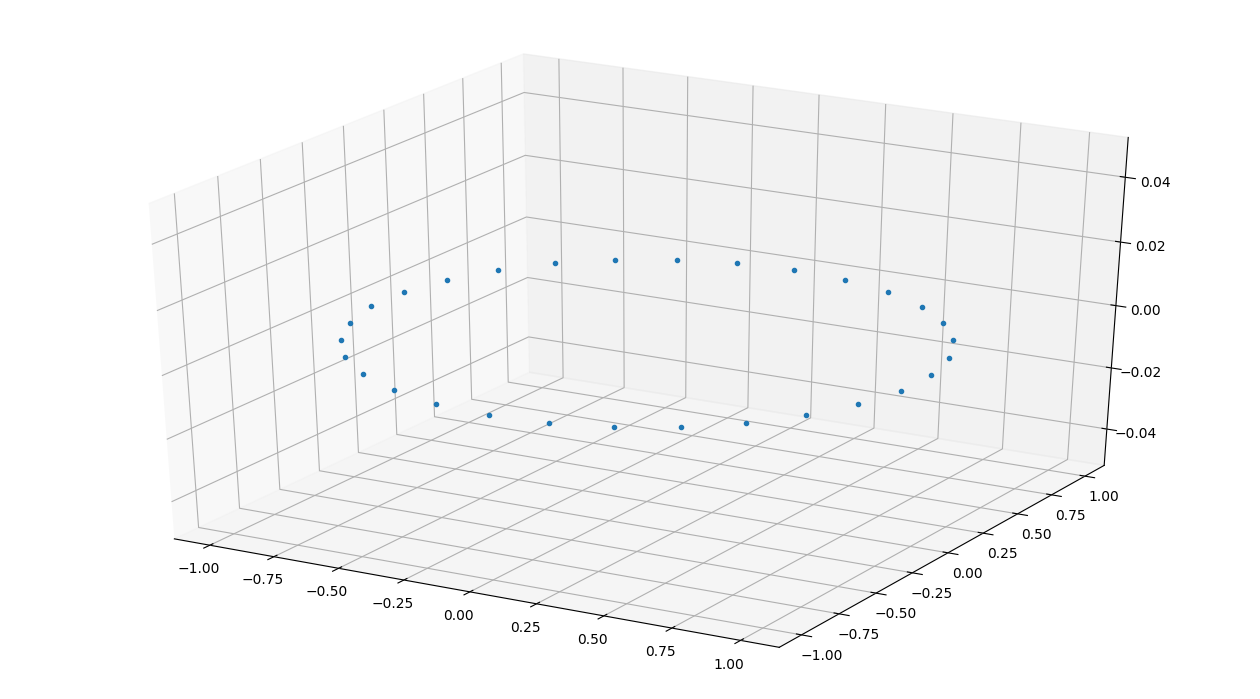

In [28]:
figsize = np.array((16, 9)) * 1
dpi = 100

fig = plt.figure(figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = fig.add_subplot(1, 1, 1, projection='3d')
axi.plot(*x1.T, '.')

In [3]:
importlib.reload(slb)
x1_fun = slb.x1_fun
T1_fun = slb.T1_fun

def KRJ_stokeslets_mij2(u_theta, f_theta, fidx, ph, rt1, rt2,
                        u_node_fun=x1_fun, f_node_fun=x1_fun, T_fun=T1_fun):
    # inner_mj = S(:, j), along u
    S = np.sqrt(4 * np.pi ** 2 * rt1 ** 2 + ph ** 2)
    intFct = S / (2 * np.pi)
    su = u_theta * intFct
    sf = f_theta * intFct
    t = T_fun(u_theta, ph, rt1, rt2)
    ds = np.abs(sf - su)
    if u_node_fun is f_node_fun:
        ds[fidx] = np.inf
    t_m = np.vstack([(np.eye(3) + np.outer(ti, ti)) / dsi for ti, dsi in zip(t.reshape(-1, 3), ds)])
    return t_m

ph = 1
rt1 = 1
rt2 = 1
u_theta = np.linspace(0, 2 * np.pi, 3)
# f_theta = 0.3 * np.pi
fidx=1

tm = KRJ_stokeslets_mij2(u_theta, u_theta[fidx], fidx, ph, rt1, rt2, 
                         u_node_fun=x1_fun, f_node_fun=x1_fun, T_fun=T1_fun)

In [4]:
Fn1Mat_fun = lambda theta, ph, rt1, rt2: \
    np.identity(3) - np.tensordot(T1_fun(theta, ph, rt1, rt2), T1_fun(theta, ph, rt1, rt2), axes=0)
Fn2Mat_fun = lambda theta, ph, rt1, rt2: \
    np.identity(3) - np.tensordot(T2_fun(theta, ph, rt1, rt2), T2_fun(theta, ph, rt1, rt2), axes=0)


In [5]:
T_fun=T1_fun
u_theta = np.array((0.1, 0.2))
t = T_fun(u_theta, ph, rt1, rt2)
print(t)
print()
temp1 = np.vstack([np.eye(3) + np.outer(ti, ti) for ti in t.reshape(-1, 3)])
print(temp1)

[[-0.09859  0.98264  0.15718]
 [-0.1962   0.96788  0.15718]]

[[ 1.00972 -0.09688 -0.0155 ]
 [-0.09688  1.96557  0.15445]
 [-0.0155   0.15445  1.0247 ]
 [ 1.03849 -0.1899  -0.03084]
 [-0.1899   1.9368   0.15213]
 [-0.03084  0.15213  1.0247 ]]


In [ ]:
[[-0.09859  0.98264  0.15718]]

[[ 0.00972 -0.09688 -0.0155 ]
 [-0.09688  0.96557  0.15445]
 [-0.0155   0.15445  0.0247 ]]

In [ ]:
[[-0.1962   0.96788  0.15718]]

[[ 0.03849 -0.1899  -0.03084]
 [-0.1899   0.9368   0.15213]
 [-0.03084  0.15213  0.0247 ]]

## 20210326, verify Eq 4.7

In [96]:
importlib.reload(slb)

ph = 1
rt1 = 1
rt2 = 0.1
theta = 0
uz, wz = 0, 1

phi_list = np.linspace(0, 2 * np.pi, 10, endpoint=False)
t_fra = slb.T1_fun(theta, ph, rt1, rt2)
n_fra = slb.N1_fun(theta, ph, rt1, rt2)
b_fra = slb.B1_fun(theta, ph, rt1, rt2)
ep = np.array([n_fra * ti for ti in np.cos(phi_list)]) + np.array([b_fra * ti for ti in np.sin(phi_list)])
x0 = slb.x1_fun(theta, ph, rt1, rt2)
x1 = x0 + ep * rt2
u1 = np.array((0, 0, uz)) + np.cross(np.array((0, 0, wz)), x1)
fft_u = np.fft.fft(2 * np.pi * u1, axis=0) / phi_list.size
# fft_u = np.fft.rfft(u1[:, 0]) * 2 / phi_list.size
usin = -fft_u.imag
ucos = fft_u.real
# print(u1[:, 0])
# print()
print(usin[:5])
# print()
print(ucos[:5])
# print()
# print(np.fft.irfft(fft_u))

# Eq 4.7 in Koens2018
t1 = 2 * (np.eye(3) + np.outer(t_fra, t_fra)) - np.outer(n_fra, n_fra) + np.outer(b_fra, b_fra)
t2 = -(np.outer(n_fra, b_fra) + np.outer(b_fra, n_fra))
t3 = 2 * (np.eye(3) + np.outer(t_fra, t_fra)) + np.outer(n_fra, n_fra) - np.outer(b_fra, b_fra)
t4 = -(np.outer(n_fra, b_fra) + np.outer(b_fra, n_fra))
tA = np.vstack((np.hstack((t1, t2)), np.hstack((t3, t4))))
tb = np.hstack((8 * ucos[1], 8 * usin[1]))
n = 1
t1 = np.eye(3) + np.outer(t_fra, t_fra)
fs, exitCode = gmres(t1, 2 * n * usin[1] / (2 * np.pi))
fc, exitCode = gmres(t1, 2 * n * ucos[1] / (2 * np.pi))
assert exitCode == 0
print(fs, np.dot(fs, t_fra), np.dot(fs, n_fra), np.dot(fs, b_fra))
print(fc, np.dot(fc, t_fra), np.dot(fc, n_fra), np.dot(fc, b_fra))
S = np.sqrt(ph ** 2 + 4 * np.pi ** 2 * rt1)
print(ph / S * (np.dot(fc, b_fra) - np.dot(fs, n_fra)) * np.pi, 2 * np.pi * rt1 / S * np.dot(fs, t_fra) * np.pi)

[[-0.00000e+00 -0.00000e+00 -0.00000e+00]
 [ 4.16334e-18 -3.14159e-01 -0.00000e+00]
 [-1.31986e-18 -0.00000e+00 -0.00000e+00]
 [-2.55249e-18  1.55431e-16 -0.00000e+00]
 [-8.15716e-19 -0.00000e+00 -0.00000e+00]]
[[-2.77556e-18  6.28319e+00  0.00000e+00]
 [ 4.93785e-02  6.66134e-17  0.00000e+00]
 [ 6.93889e-19  0.00000e+00  0.00000e+00]
 [ 5.55112e-18 -3.22096e-17  0.00000e+00]
 [ 6.93889e-19  8.88178e-17  0.00000e+00]]
[ 1.32523e-18 -5.12352e-02  7.76115e-03] -0.04937852460756961 0.01571767254775899 -1.3252311172764656e-18
[1.57177e-02 2.12037e-17 0.00000e+00] 2.0940146347248926e-17 -3.3327278002323632e-18 -0.015717672547758986
-0.015522309613464763 -0.1531990552761235


Text(0, 0.5, '$\\kappa$')

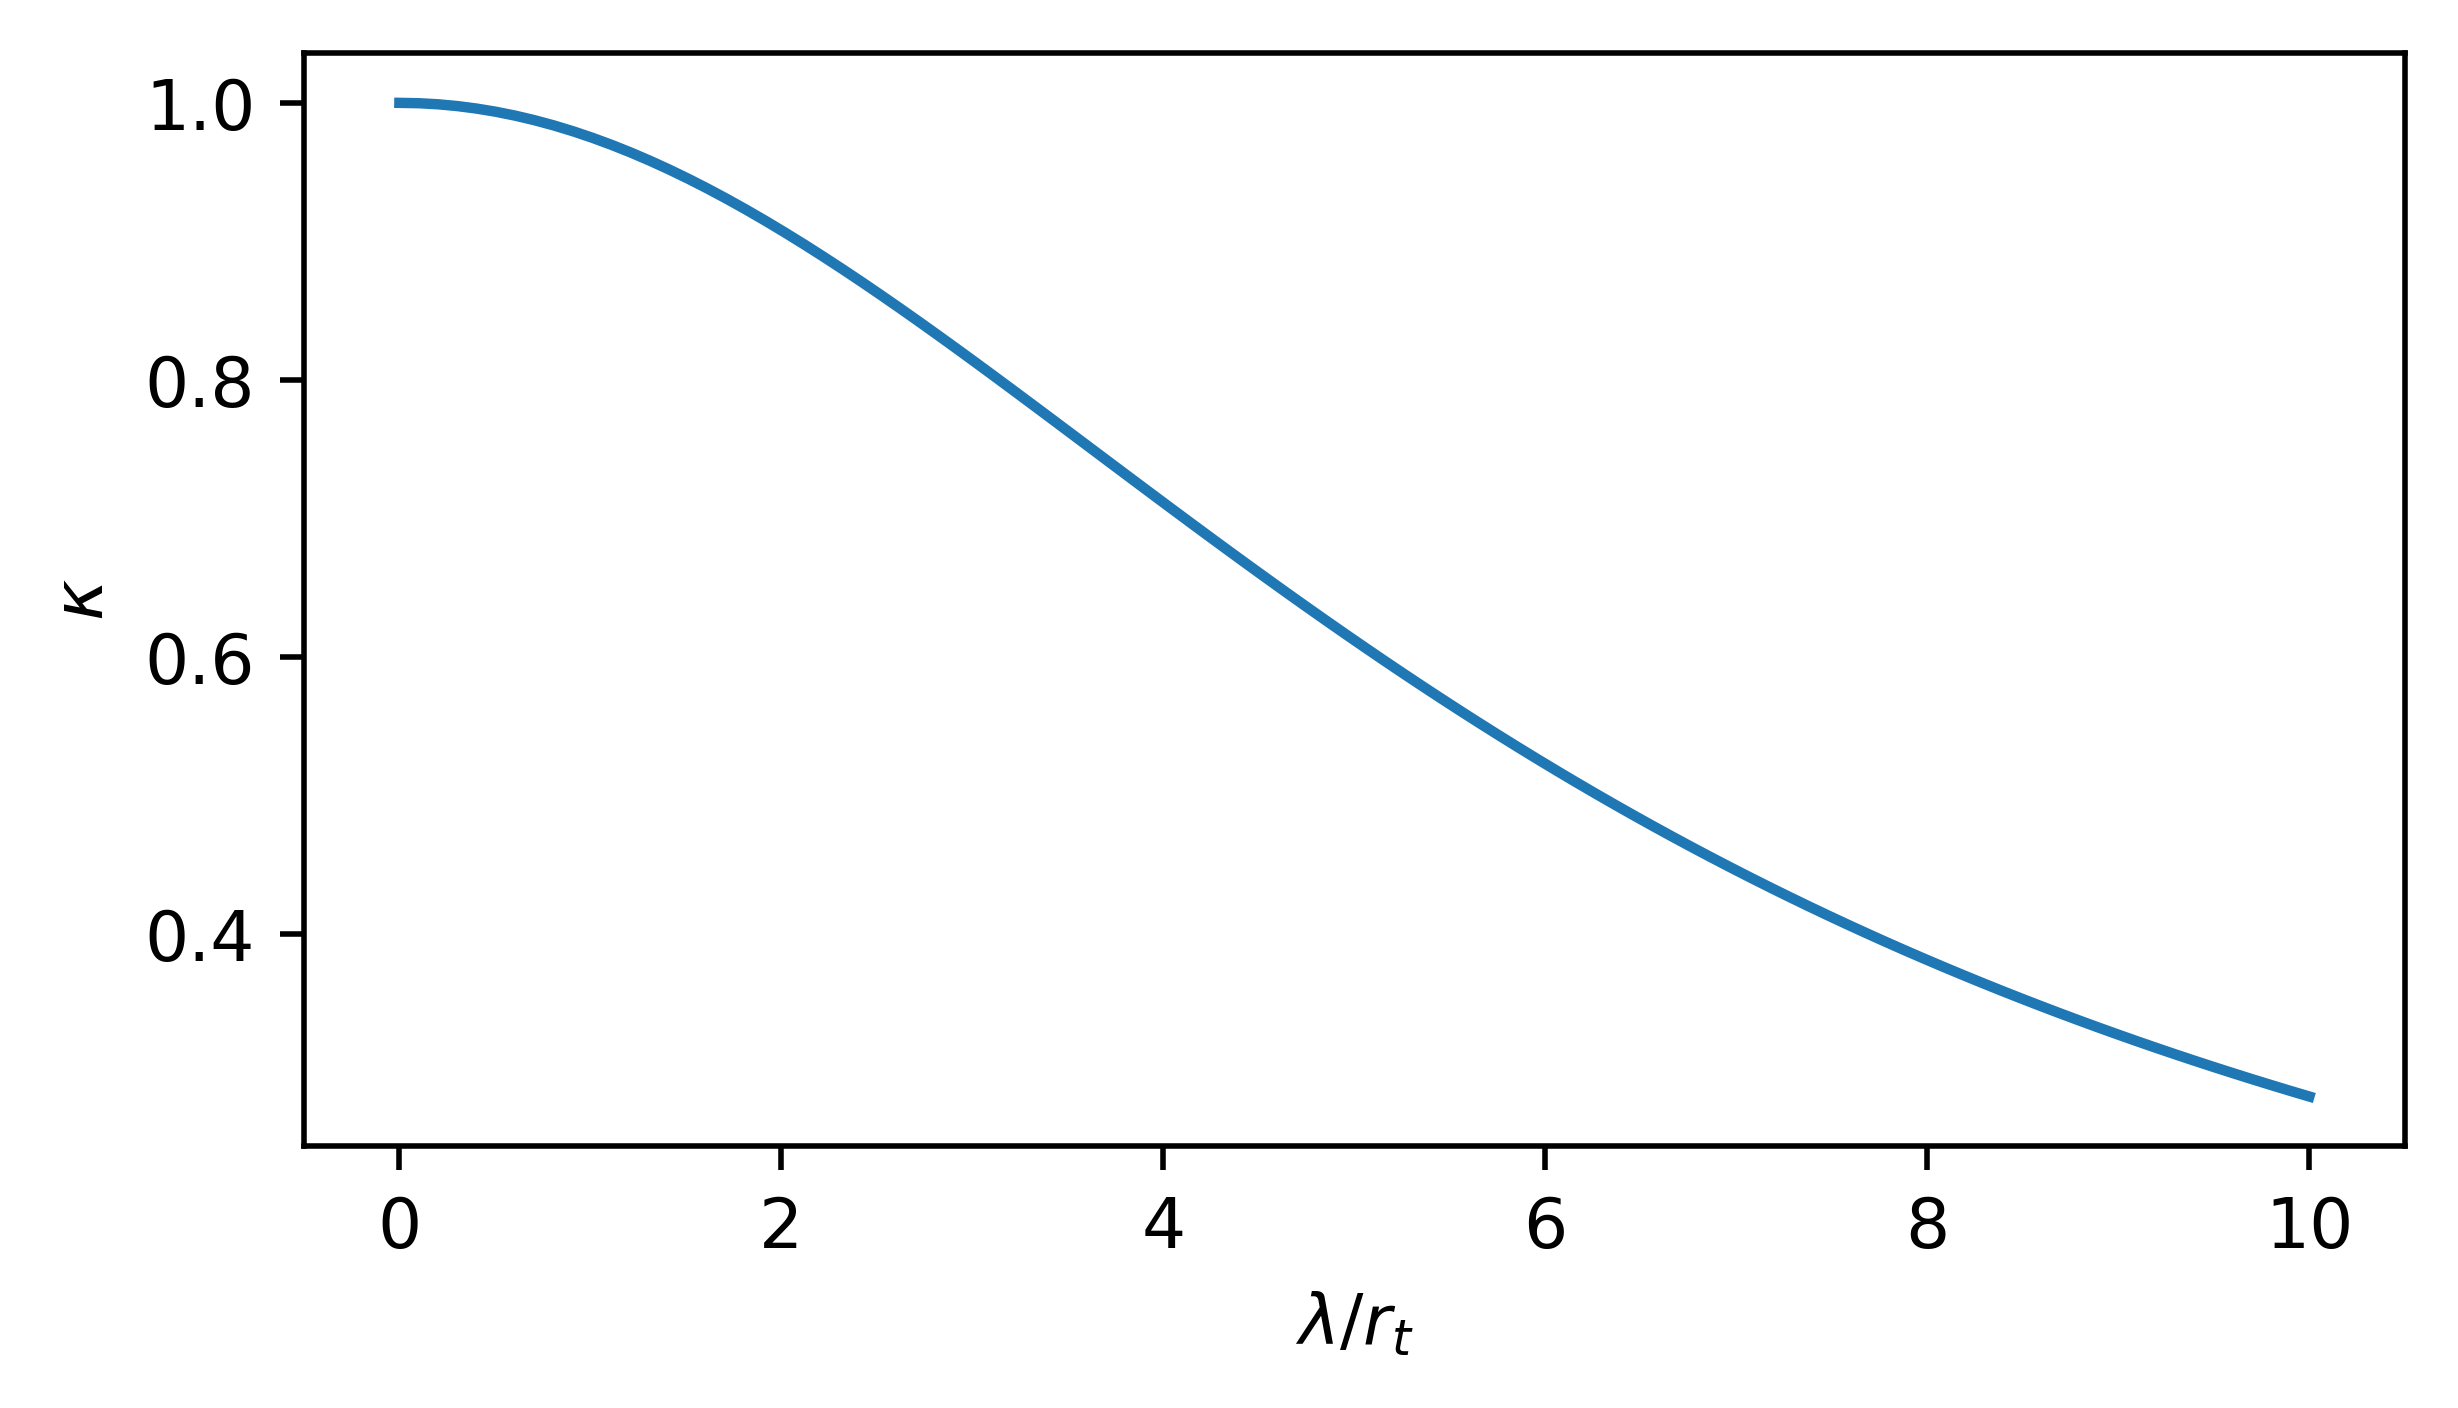

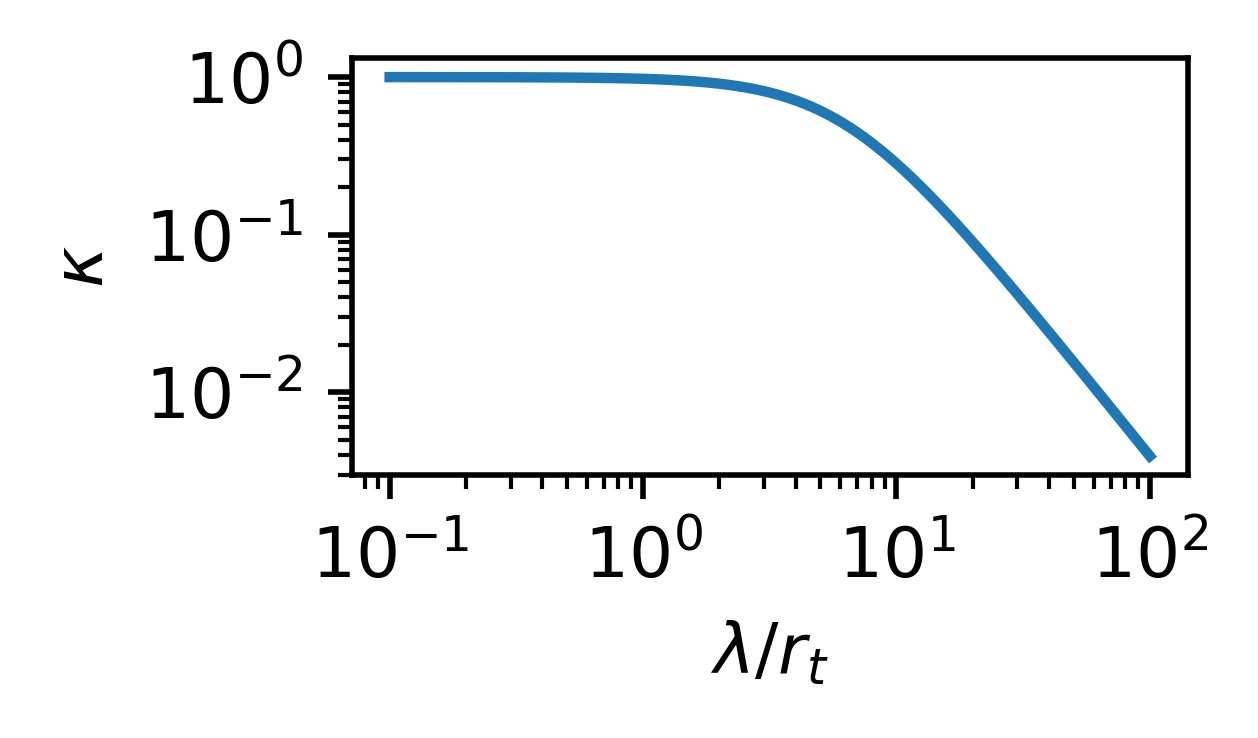

In [120]:
rt1 = 1
ph_list = np.linspace(0, 10, 100)
figsize = np.array((16, 9)) * 0.3
dpi = 500

fig, axi = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=dpi, constrained_layout=True)
fig.patch.set_facecolor('white')
kappa = rt1 / (rt1 ** 2 + (ph_list / (2 * np.pi)) ** 2)
axi.plot(ph_list, kappa)
axi.set_xlabel('$\lambda / r_t$')
axi.set_ylabel('$\kappa$')

#################################################

figsize = np.array((16, 9)) * 0.15
dpi = 500
ph_list = 10 ** np.linspace(-1, 2, 100)

fig, axi = plt.subplots(nrows=1, ncols=1, figsize=figsize, dpi=dpi, constrained_layout=True)
# fig.patch.set_facecolor('white')
kappa = rt1 / (rt1 ** 2 + (ph_list / (2 * np.pi)) ** 2)
axi.loglog(ph_list, kappa)
axi.set_xlabel('$\lambda / r_t$')
axi.set_ylabel('$\kappa$')


In [112]:
33.26 / 19.05, 16 / 9

(1.7459317585301835, 1.7777777777777777)